# discharge notes

In [1]:
#configure for local eicu databse
import nltk
import os
print(os.getcwd())
#configure for local mimic databse
exec(open("../configs/configure_mimic.py").read())
exec(open("my_functions.py").read())

/Users/grovesdixon/gitreps/Insight_fellowship_project/project_framework

Configured for local MIMIC database:
	user = postgres
	dbname = mimic
	host = localhost
	schema_name = mimiciii
	query_schema = SET search_path to mimiciii;


### load noteevents

In [2]:
query = query_schema + 'select * from noteevents'

query = query_schema + """
select 
    hadm_id,
    text
from noteevents
where category = 'Discharge summary';
"""

df = pd.read_sql_query(query,con)
df.head()

,hadm_id,text
0,167853,Admission Date: [**2151-7-16**] Dischar...
1,107527,Admission Date: [**2118-6-2**] Discharg...
2,167118,Admission Date: [**2119-5-4**] D...
3,196489,Admission Date: [**2124-7-21**] ...
4,135453,Admission Date: [**2162-3-3**] D...


### clean the text
remove frequent endlines and bracketted strings for protected information

In [3]:
ctext = df['text']
ctext = pd.Series([x.lower() for x in ctext])
replacements = {'\[\*\*.*\*\*\]': 'REMOVEDTEXT',
               '\n': ' '}
ctext = ctext.replace(replacements, regex=True)
df['text'] = ctext
df.head()

,hadm_id,text
0,167853,admission date: REMOVEDTEXT service: addend...
1,107527,admission date: REMOVEDTEXT date of birth: ...
2,167118,admission date: REMOVEDTEXT service: cardio...
3,196489,admission date: REMOVEDTEXT service: medici...
4,135453,admission date: REMOVEDTEXT date of birth: ...


### call presence of elements
There are particular elements that appear in the notes, but are not always present. Will use the presence of these as potential features.

In [4]:
#set up list of elements found in the discharge notes
element_list = ['admission date:',
                'chief complaint:',
                'sex:',
               'history of present illness:']


#split out the text elements
tdat = df.loc[:,['hadm_id'].copy()]
for e in element_list:
    #first assign presence absence
    print('{}...'.format(e))
    pa_col = e.replace(':', '') + '_presnt'
    df[pa_col] = df['text'].str.contains(e).astype(int)
    print('\t{} instances detected out of {} rows'.format(np.sum(df[pa_col]), df.shape[0]))
df.head()

admission date:...
	59585 instances detected out of 59652 rows
chief complaint:...
	41370 instances detected out of 59652 rows
sex:...
	51905 instances detected out of 59652 rows
history of present illness:...
	50578 instances detected out of 59652 rows


,hadm_id,text,admission date_presnt,chief complaint_presnt,sex_presnt,history of present illness_presnt
0,167853,admission date: REMOVEDTEXT service: addend...,1,0,0,0
1,107527,admission date: REMOVEDTEXT date of birth: ...,1,0,1,1
2,167118,admission date: REMOVEDTEXT service: cardio...,1,1,0,1
3,196489,admission date: REMOVEDTEXT service: medici...,1,1,0,1
4,135453,admission date: REMOVEDTEXT date of birth: ...,1,1,1,1


# get word frequencies 

In [5]:
#prepare data
tdat = df.loc[:,['hadm_id', 'text']].copy()
tdat.index = tdat['hadm_id']
tdat = tdat.loc[~tdat.index.duplicated(keep='first')]

### get tokens
split notes into tokens and remove stopwords

In [6]:
from nltk.corpus import stopwords

#function to generate and clean the tokens
def clean_tokens(x):
    x=pd.Series(x.split(), dtype='object')
    return list(x[~x.isin(stopwords.words('english'))])

#tokenize
token_df = tdat.copy()
token_df['text'] = token_df['text'].apply(clean_tokens) 
token_df

#gather word count as a feature
wc_df = token_df.copy()
wc_df['wc'] = wc_df['text'].apply(len)
wc_df = wc_df.drop('text', 1)

### get word frequencies

In [7]:
#get word frequencies
print('getting frequencies...')
freq_df = token_df.copy()
freq_df['text'] = freq_df['text'].apply(nltk.FreqDist)
freq_df.head()

getting frequencies...


,hadm_id,text
hadm_id,,
167853,167853,"{'admission': 1, 'date:': 1, 'REMOVEDTEXT': 5,..."
107527,107527,"{'admission': 2, 'date:': 1, 'REMOVEDTEXT': 21..."
167118,167118,"{'admission': 2, 'date:': 1, 'REMOVEDTEXT': 35..."
196489,196489,"{'admission': 2, 'date:': 1, 'REMOVEDTEXT': 30..."
135453,135453,"{'admission': 2, 'date:': 1, 'REMOVEDTEXT': 17..."


### format into long df

In [8]:
#build dataframe cor column
c='text'
fdf_list = []
for i in freq_df.index:
    sub_df = pd.DataFrame.from_dict(freq_df.loc[i,c], orient='index')
    sub_df['hadm_id'] = i
    fdf_list.append(sub_df)
fdat = pd.concat(fdf_list)
fdat.columns = ['count', 'hadm_id']
fdat['word'] = fdat.index

### select words based on content and frequency
also remove short words and numbers

In [9]:
word_counts = fdat['word'].value_counts()
print('starting total words = {}'.format(len(word_counts)))
keep = word_counts.index[(word_counts > 25) & (word_counts < 10000)].to_series()
word_lengths = keep.str.len()
keep = keep[word_lengths>3]
keep = keep[~keep.str.contains('[^\w]')]
keep = keep[~keep.str.contains('[\d]')]
keep = keep[~keep.str.contains('__')]
keep = keep[~keep.str.contains('REMOVEDTEXT')]

print('total words appearing kept = {}'.format(len(keep)))
common_fdat = fdat.loc[fdat['word'].isin(keep),:]
common_fdat.head()

starting total words = 664705
total words appearing kept = 14085


,count,hadm_id,word
radiologic,2,167853,radiologic
studies,1,167853,studies
included,1,167853,included
confirmed,1,167853,confirmed
cavitary,1,167853,cavitary


### pivot and convert to present absence

In [10]:
dn_dat = common_fdat.pivot(index='hadm_id', columns='word', values='count').fillna(value=0).astype('int')
dn_dat

word,abacavir,abandoned,abated,abbreviated,abcess,abcesses,abdm,abdom,abdomenal,abdominial,...,zones,zonisamide,zoster,zosyn,zydis,zygoma,zygomatic,zyprexa,zyrtec,zyvox
hadm_id,,,,,,,,,,,,,,,,,,,,,
100001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## select features

In [11]:
#load training outcomes
import joblib
y_train = joblib.load(open('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/y_train.joblib', 'rb')) #build this with feature_engineering.ipynb
train_pos_hadm_ids = y_train.index[y_train==1]
print(len(train_pos_hadm_ids))
y_train

908


hadm_id
151832    0
161862    0
134243    0
193634    0
120867    0
         ..
172452    0
174906    0
156353    0
177151    0
152128    0
Name: hrrd_penalized, Length: 35164, dtype: int64

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
def logistic_select_features(dat, y_train, feature_col, threshold):
    """feature selection using l1 regularization.
    dat = full dataset of features
    y_train = the training outcome data indexed with hadm_id
    The data are subset to match just the test set, then logistic regression coefficient is used for selection"""
    #make sure data and training outputs line up
    dat_for_train = dat.copy()
    dat_ids = set(dat_for_train.index)
    y_ids = set(y_train.index)
    shared_ids = list(dat_ids.intersection(y_ids))
    dat_X_train = dat_for_train.loc[shared_ids,:] #first subset for training set
    dat_y_train = y_train.loc[shared_ids]   #then subset outcomes to match
    matched = np.sum(dat_X_train.index==dat_y_train.index) ==dat_X_train.shape[0]
    print('training data and outcomes matched = {}'.format(matched))
    print('total ids used for training = {}'.format(dat_X_train.shape[0]))
    #do selection
    sel = SelectFromModel(estimator=LogisticRegression(max_iter=1000),
                         threshold = threshold).fit(dat_X_train, dat_y_train)
    coefs = sel.estimator_.coef_
    #write out for prettier plotting
    pd.DataFrame({'coef':coefs[0]}).to_csv('../data/for_plotting/' + feature_col + '_coefs.csv',
                                          index=False)
    #plot the distribution of coefficients
    plt.hist(coefs[0], bins=100)
    plt.xlabel('coeficient')
    plt.ylabel('frequency')
    plt.title('before selection')
    plt.show()
    #plot the distribution of coefficients after selection
    plt.hist(coefs[0][sel.get_support()], bins=100)
    plt.xlabel('coeficient')
    plt.ylabel('frequency')
    plt.title('after selection')
    plt.show()
    #make selections
    print(np.mean(np.absolute(coefs)))
    print('selector threshold = {}'.format(sel.threshold_))
    sel.get_support()
    nonZeroN = np.sum(sel.get_support())
    print('{} total featuers had nonzero coefficients after selection'.format(nonZeroN))
    res = dat.loc[:,list(dat_X_train.columns[sel.get_support()])]
    return res

898 of 568 total words appear in more than 10% of notes for positive patients
Index(['abnormal', 'abnormality', 'accessory', 'acid', 'active', 'added',
       'addition', 'additional', 'adequate', 'adhere',
       ...
       'weigh', 'went', 'wheezes', 'wife', 'woman', 'worked', 'workup',
       'worse', 'wound', 'zosyn'],
      dtype='object', name='word', length=568)
training data and outcomes matched = True
total ids used for training = 34263


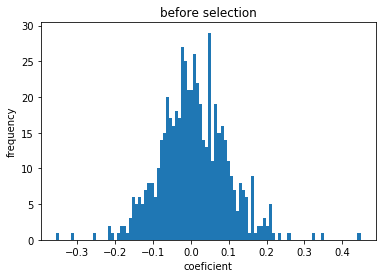

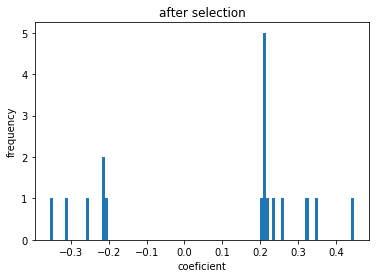

0.06920321032219566
selector threshold = 0.2
18 total featuers had nonzero coefficients after selection


In [13]:
padn_dat = dn_dat.copy() > 0
padn_dat = padn_dat.astype(int).loc[padn_dat.index.isin(train_pos_hadm_ids)]
freqs = padn_dat.sum() / len(padn_dat.index.unique())
keep = freqs.index[freqs > 1/10]
print('{} of {} total words appear in more than 10% of notes for positive patients'.format(padn_dat.shape[0], len(keep)))
print(keep)
tdn_dat = dn_dat.loc[:,keep]
notes_dat = logistic_select_features(dn_dat.loc[:,keep], y_train, 'dischargeNotes', 0.2)

### write out

In [23]:
notes_dat.to_csv('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/discharge_note_features.csv')